Connecting Drive to Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Time Series Forecasting means analyzing and modeling time-series data to make future decisions. Some of the applications of Time Series Forecasting are weather forecasting, sales forecasting, business forecasting, stock price forecasting, etc. The ARIMA model is a popular statistical technique used for Time Series Forecasting. If you want to learn Time Series Forecasting with ARIMA, this article is for you. In this article, I will take you through the task of Time Series Forecasting with ARIMA using the Python programming language.

What is ARIMA?
ARIMA stands for Autoregressive Integrated Moving Average. It is an algorithm used for forecasting Time Series Data. ARIMA models have three parameters like ARIMA(p, d, q). Here p, d, and q are defined as:

1. p is the number of lagged values that need to be added or subtracted from the values (label column). It captures the autoregressive part of ARIMA.
2. d represents the number of times the data needs to differentiate to produce a stationary signal. If it’s stationary data, the value of d should be 0, and if it’s seasonal data, the value of d should be 1. d captures the integrated part of ARIMA.
3. q is the number of lagged values for the error term added or subtracted from the values (label column). It captures the moving average part of ARIMA.

Importing Necessary Libraries and read the data

In [2]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG',
                      start=start_date,
                      end=end_date,
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
246 2023-10-31  126.269997  126.559998  123.925003  125.300003  125.300003   
247 2023-11-01  125.339996  127.739998  124.925003  127.570000  127.570000   
248 2023-11-02  129.559998  130.089996  128.110001  128.580002  128.580002   
249 2023-11-03  129.089996  130.729996  129.009995  130.369995  130.369995   
250 2023-11-06  130.220001  131.559998  129.929993  131.449997  131.449997   

       Volume  
246  21123400  
247  26536600  
248  24091700  
249  19517900  
250  15350300  


We only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further:

In [3]:
data = data[["Date", "Close"]]
print(data.head())

        Date      Close
0 2022-11-07  88.650002
1 2022-11-08  88.910004
2 2022-11-09  87.400002
3 2022-11-10  94.169998
4 2022-11-11  96.730003


Now let’s visualize the close prices of Google before moving forward:

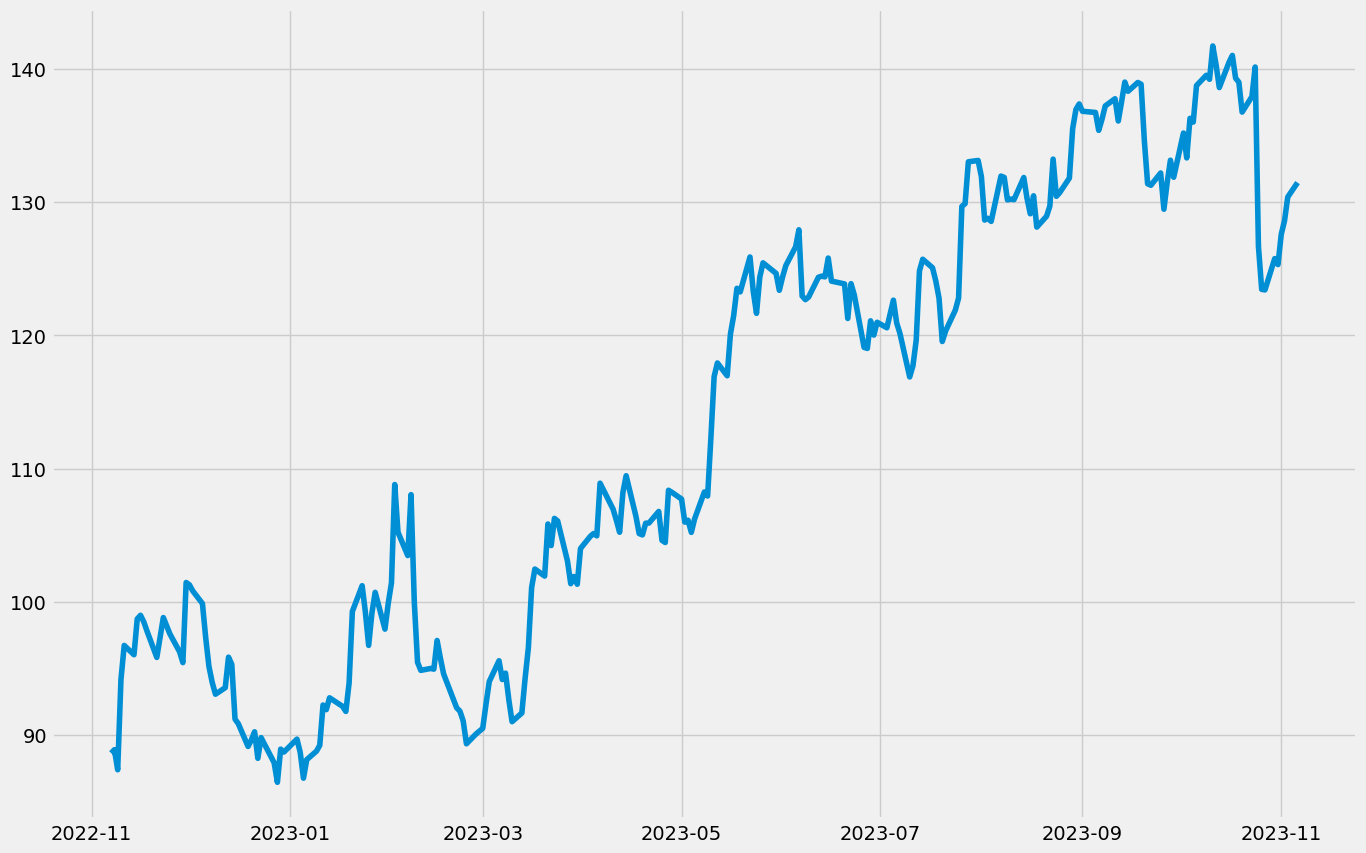

In [4]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

Before using the ARIMA model, we have to figure out whether our data is stationary or seasonal. The data visualization graph about the closing stock prices above shows that our dataset is not stationary. To check whether our dataset is stationary or seasonal properly, we can use the seasonal decomposition method that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data:

<Figure size 640x480 with 0 Axes>

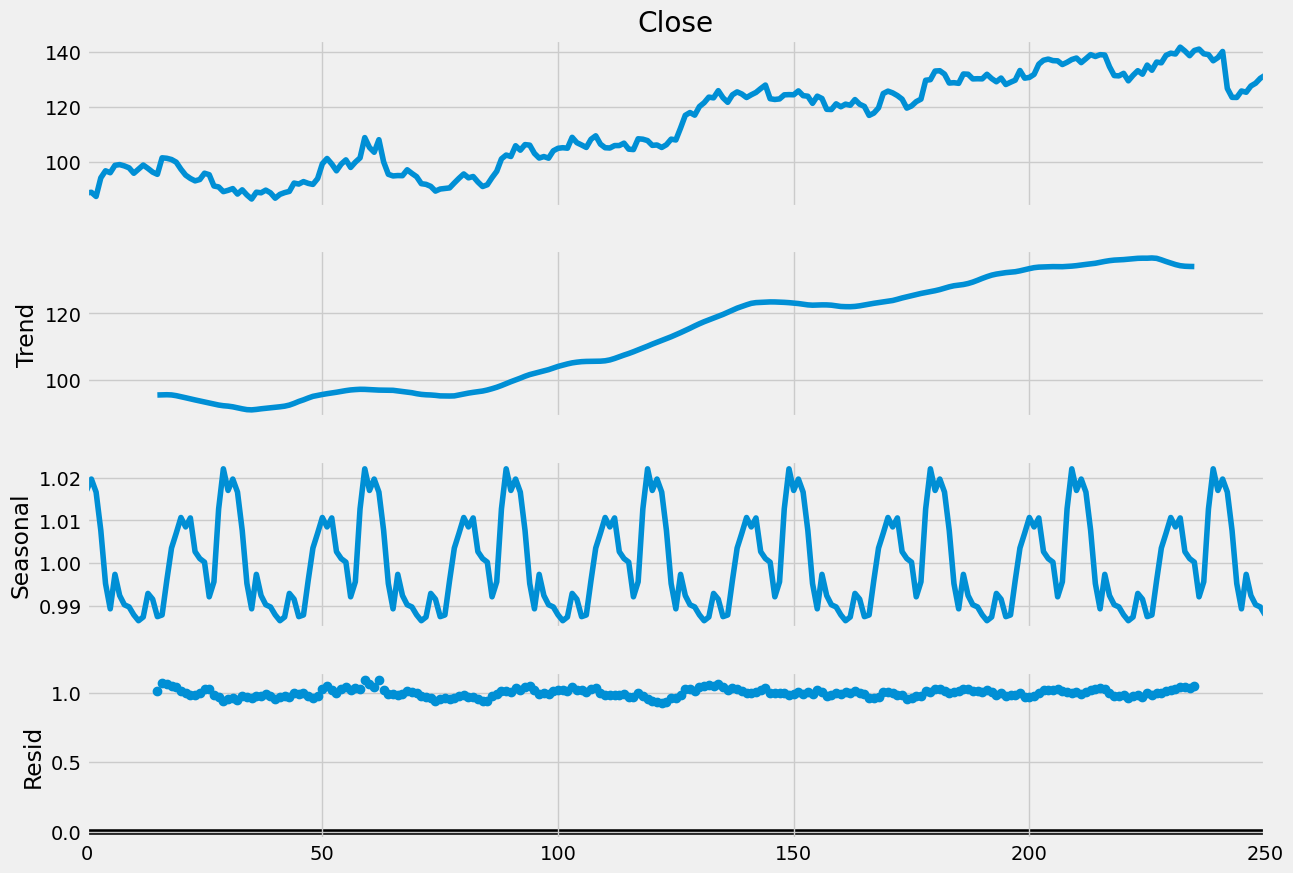

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"],
                            model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 10)

So our data is not stationary it is seasonal. We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. But before using the SARIMA model, we will use the ARIMA model. It will help you learn using both models.

To use ARIMA or SARIMA, we need to find the p, d, and q values. We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

Now here’s how to find the value of p:

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

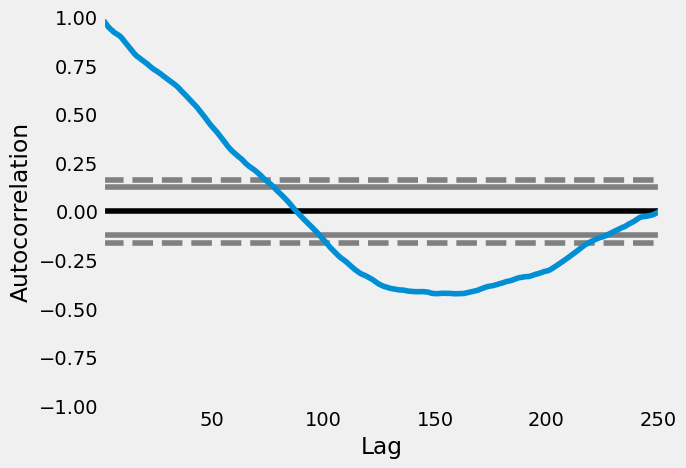

In [6]:
pd.plotting.autocorrelation_plot(data["Close"])

In the above autocorrelation plot, the curve is moving down after the 6th line of the first boundary. That is how to decide the p-value. Hence the value of p is 6. Now let’s find the value of q (moving average):

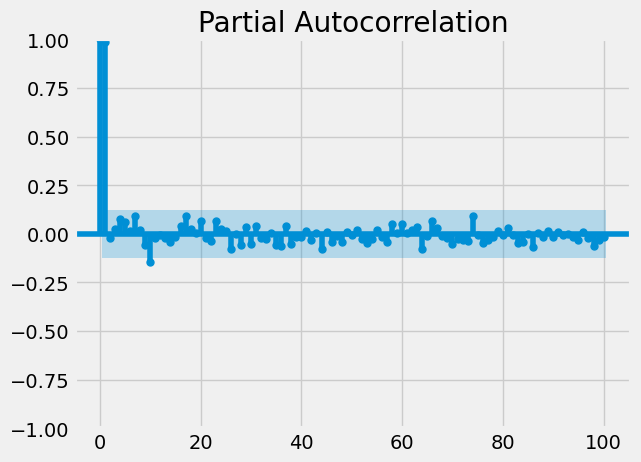

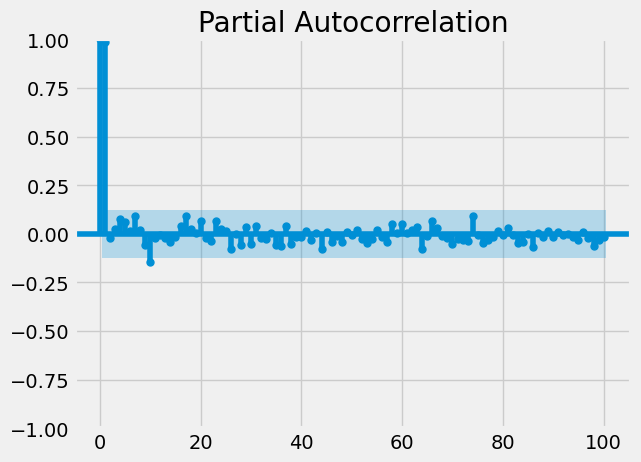

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 1. Now let’s build an ARIMA model:

In [10]:
p, d, q = 6, 1, 1
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -560.238
Date:                Tue, 07 Nov 2023   AIC                           1136.476
Time:                        03:45:19   BIC                           1164.647
Sample:                             0   HQIC                          1147.814
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1383      1.150      0.120      0.904      -2.116       2.392
ar.L2         -0.0712      0.092     -0.771      0.441      -0.252       0.110
ar.L3          0.0087      0.104      0.083      0.9

Here’s how to predict the values using the ARIMA model:

In [11]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1       88.650022
2       88.921579
3       87.312327
4       94.586892
          ...    
246    126.244190
247    125.641095
248    128.732177
249    128.680114
250    130.339365
Name: predicted_mean, Length: 251, dtype: float64


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model:

In [12]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(6, 1, 1)x(6, 1, 1, 12)   Log Likelihood                -548.709
Date:                            Tue, 07 Nov 2023   AIC                           1127.419
Time:                                    03:47:32   BIC                           1179.503
Sample:                                         0   HQIC                          1148.410
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1458      1.334      0.109      0.913      -2.468       2.760
ar.L2         -0.0844      0.114   

Now let’s predict the future stock prices using the SARIMA model for the next 10 days:

In [13]:
predictions = model.predict(len(data), len(data)+10)
print(predictions)

251    131.583380
252    132.260582
253    131.624518
254    131.494721
255    130.547080
256    130.781001
257    130.901539
258    132.171920
259    132.908329
260    132.296158
261    132.676864
Name: predicted_mean, dtype: float64


Here’s how you can plot the predictions:

<Axes: >

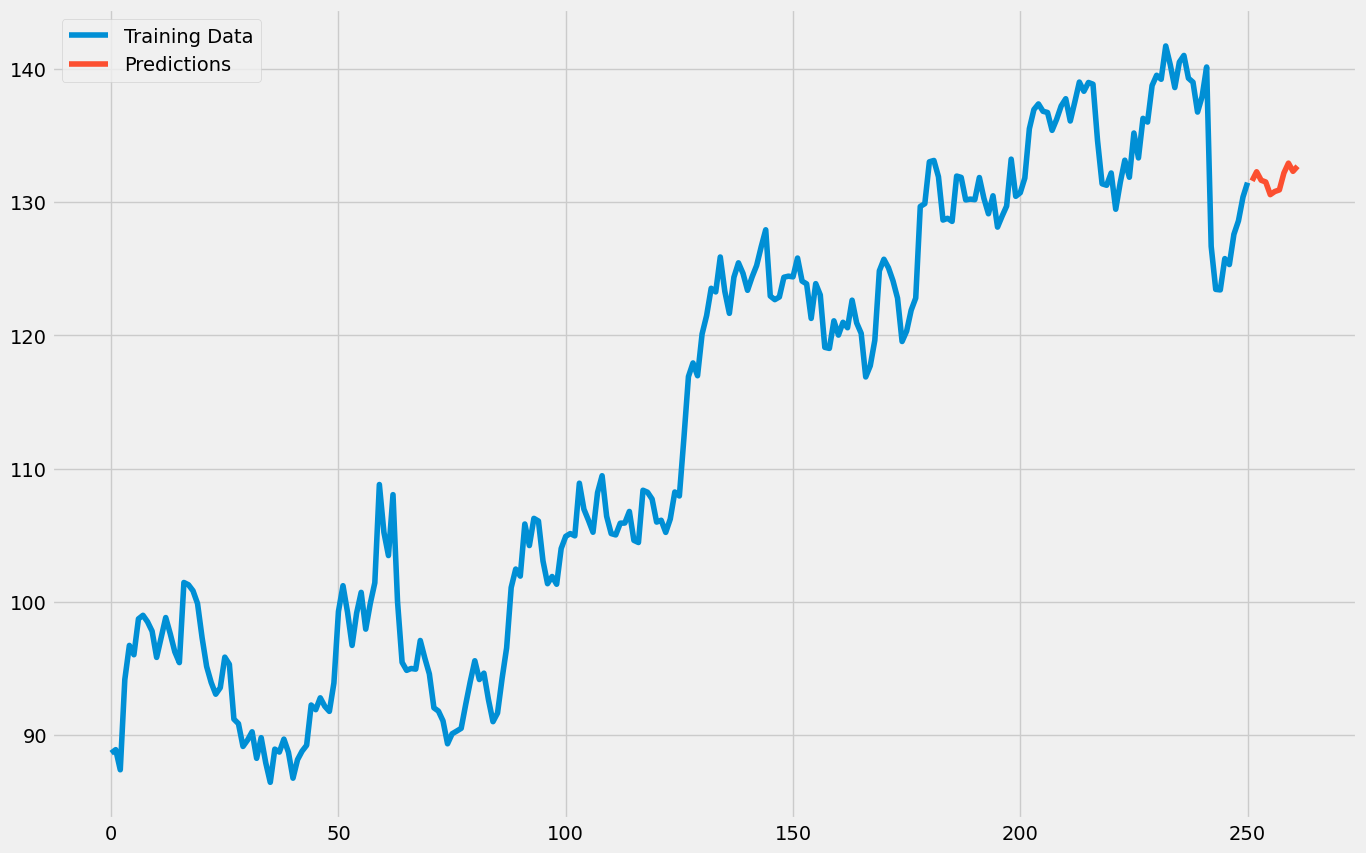

In [14]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

ARIMA stands for Autoregressive Integrated Moving Average. It is an algorithm used for forecasting Time Series Data. If the data is stationary, we need to use ARIMA, if the data is seasonal, we need to use Seasonal ARIMA (SARIMA).